In [64]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import datetime
from tensorflow.keras import Model, Sequential

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError,RootMeanSquaredError


from tensorflow.keras.layers import Dense, Conv1D, LSTM, Lambda, Reshape, RNN, LSTMCell

import warnings
warnings.filterwarnings('ignore')

In [65]:
drop_list=["Date","Open","High","Low","Close","Volume","SMA_7","SMA_14","EMA_7","EMA_14","RSI","Stoch_RSI","Upper_BB","Lower_BB","MACD"]
# drop_list=["Date","Open","High","Low","Close","Volume","SMA_14","EMA_14"]
train_df = pd.read_csv('data/train.csv').drop(drop_list,axis=1)
val_df = pd.read_csv('data/val.csv').drop(drop_list,axis=1)
test_df = pd.read_csv('data/test.csv').drop(drop_list,axis=1)

print(train_df.shape, val_df.shape, test_df.shape)

(2246, 1) (642, 1) (294, 1)


In [66]:
train_df

,Adj Close
0,400.869995
1,394.773010
2,382.556000
3,383.757996
4,391.441986
...,...
2241,19201.091797
2242,19445.398438
2243,18699.765625
2244,19154.230469


In [67]:
# timestamp_s = pd.to_datetime(train_df['Date']).map(datetime.datetime.timestamp)
# train_df['Coin_timestamp'] = timestamp_s
# train_df = train_df.drop(['Date'], axis=1)

# timestamp_s = pd.to_datetime(val_df['Date']).map(datetime.datetime.timestamp)
# val_df['Coin_timestamp'] = timestamp_s
# val_df = val_df.drop(['Date'], axis=1)

# timestamp_s = pd.to_datetime(test_df['Date']).map(datetime.datetime.timestamp)
# test_df['Coin_timestamp'] = timestamp_s
# test_df = test_df.drop(['Date'], axis=1)

In [68]:
train_df

,Adj Close
0,400.869995
1,394.773010
2,382.556000
3,383.757996
4,391.441986
...,...
2241,19201.091797
2242,19445.398438
2243,18699.765625
2244,19154.230469


## `DataWindow` class 

In [69]:
class DataWindow():
    def __init__(self, input_width, label_width, shift, 
                 train_df=train_df, val_df=val_df, test_df=test_df, 
                 label_columns=None):
        
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
        
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
        self.column_indices = {name: i for i, name in enumerate(train_df.columns)}
        
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift
        
        self.total_window_size = input_width + shift
        
        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]
        
        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]
    
    def split_to_inputs_labels(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:,:,self.column_indices[name]] for name in self.label_columns],
                axis=-1
            )
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])
        
        return inputs, labels
    
    def plot(self, model=None, plot_col='Adj Close', max_subplots=3):
        inputs, labels = self.sample_batch
        
        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))
        
        for n in range(max_n):
            plt.subplot(3, 1, n+1)
            plt.ylabel(f'{plot_col} [scaled]')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                     label='Inputs', marker='.', zorder=-10)

            if self.label_columns:
              label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
              label_col_index = plot_col_index

            if label_col_index is None:
              continue

            plt.scatter(self.label_indices, labels[n, :, label_col_index],
                        edgecolors='k', marker='s', label='Labels', c='green', s=64)
            if model is not None:
              predictions = model(inputs)
              plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                          marker='X', edgecolors='k', label='Predictions',
                          c='red', s=64)

            if n == 0:
              plt.legend()

        plt.xlabel('Time (h)')
        
    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=True,
            batch_size=64
        )
        
        ds = ds.map(self.split_to_inputs_labels)
        return ds
    
    @property
    def train(self):
        return self.make_dataset(self.train_df)
    
    @property
    def val(self):
        return self.make_dataset(self.val_df)
    
    @property
    def test(self):
        return self.make_dataset(self.test_df)
    
    @property
    def sample_batch(self):
        result = getattr(self, '_sample_batch', None)
        if result is None:
            result = next(iter(self.train))
            self._sample_batch = result
        return result

In [70]:
def compile_and_fit(model, window, patience=3, max_epochs=100):
    early_stopping = EarlyStopping(monitor='val_loss',
                                   patience=patience,
                                   mode='min')
    
    model.compile(loss=MeanSquaredError(),
                  optimizer=Adam(),
                  metrics=[MeanAbsoluteError()])
        # RootMeanSquaredError
        # MeanAbsoluteError
    history = model.fit(window.train,
                       epochs=max_epochs,
                       validation_data=window.val,
                       callbacks=[early_stopping])
    
    return history

In [71]:
column_indices = {name: i for i, name in enumerate(train_df.columns)}

In [72]:
multi_window = DataWindow(input_width=7, label_width=7, shift=1,label_columns=['Adj Close'])

In [73]:
Train_performance = {}
Test_performance = {}

## LSTM model 

In [74]:
lstm_model = Sequential([
    LSTM(150, return_sequences=True, activation='relu'),
    # LSTM(150, return_sequences=True, activation='relu'),
    LSTM(150, activation='relu'),
    
    Dense(150, activation='relu'),
    # Dense(150, activation='relu'),
    Dense(1),
])

history = compile_and_fit(lstm_model, multi_window)

Train_performance['LSTM'] = lstm_model.evaluate(multi_window.train, verbose=0)
Test_performance['LSTM'] = lstm_model.evaluate(multi_window.test, verbose=0)
print(Train_performance)
print(Test_performance)

Epoch 1/100
35/35 [==============================] - 5s 91ms/step - loss: 12252764.0000 - mean_absolute_error: 1899.5824 - val_loss: 5058724.0000 - val_mean_absolute_error: 1606.3005
Epoch 2/100
35/35 [==============================] - 3s 89ms/step - loss: 156599.1875 - mean_absolute_error: 187.8234 - val_loss: 4215726.5000 - val_mean_absolute_error: 1457.1270
Epoch 3/100
35/35 [==============================] - 3s 80ms/step - loss: 132251.0312 - mean_absolute_error: 179.0111 - val_loss: 3736079.2500 - val_mean_absolute_error: 1429.9585
Epoch 4/100
35/35 [==============================] - 3s 79ms/step - loss: 143581.1719 - mean_absolute_error: 183.9802 - val_loss: 4661642.5000 - val_mean_absolute_error: 1565.3075
Epoch 5/100
35/35 [==============================] - 3s 82ms/step - loss: 141410.3438 - mean_absolute_error: 178.7030 - val_loss: 4058220.5000 - val_mean_absolute_error: 1472.6952
Epoch 6/100
35/35 [==============================] - 3s 80ms/step - loss: 143009.3906 - mean_abso

In [25]:
Train_performance['LSTM'] = lstm_model.evaluate(multi_window.train, verbose=0)
Test_performance['LSTM'] = lstm_model.evaluate(multi_window.test, verbose=0)
print(Train_performance)
print(Test_performance)

{'LSTM': [3461885.75, 1860.6143798828125]}
{'LSTM': [218360496.0, 14777.025390625]}


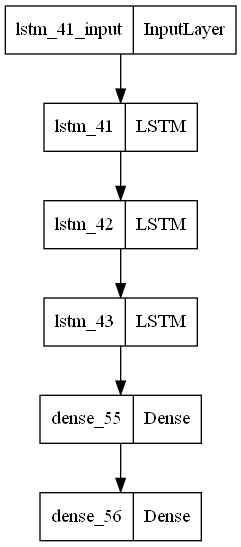

In [62]:
from keras.utils import plot_model
# tf.keras.utils.plot_model(lstm_model, to_file='Functional_API_model.png')
tf.keras.utils.plot_model(lstm_model)

## CNN model 

In [367]:
KERNEL_WIDTH = 3
LABEL_WIDTH = 7
INPUT_WIDTH = LABEL_WIDTH + KERNEL_WIDTH - 1

cnn_multi_window = DataWindow(input_width=INPUT_WIDTH, label_width=LABEL_WIDTH, shift=1, label_columns=['Adj Close'])

In [368]:
cnn_model = Sequential([
    Conv1D(32, activation='relu', kernel_size=(KERNEL_WIDTH)),
    
    Dense(units=8, activation='relu'),
    Dense(1, kernel_initializer=tf.initializers.zeros),
])

history = compile_and_fit(cnn_model, cnn_multi_window)



Train_performance['CNN'] = cnn_model.evaluate(cnn_multi_window.train, verbose=0)
Test_performance['CNN'] = cnn_model.evaluate(cnn_multi_window.test, verbose=0)

Epoch 1/1000
70/70 [==============================] - 3s 5ms/step - loss: 31874354.0000 - root_mean_squared_error: 5645.7378 - val_loss: 457367360.0000 - val_root_mean_squared_error: 21386.1504
Epoch 2/1000
70/70 [==============================] - 0s 2ms/step - loss: 1619174.0000 - root_mean_squared_error: 1272.4677 - val_loss: 4066973.2500 - val_root_mean_squared_error: 2016.6738
Epoch 3/1000
70/70 [==============================] - 0s 2ms/step - loss: 137795.3594 - root_mean_squared_error: 371.2079 - val_loss: 4037870.2500 - val_root_mean_squared_error: 2009.4454
Epoch 4/1000
70/70 [==============================] - 0s 2ms/step - loss: 136856.1875 - root_mean_squared_error: 369.9408 - val_loss: 4079482.2500 - val_root_mean_squared_error: 2019.7728
Epoch 5/1000
70/70 [==============================] - 0s 3ms/step - loss: 136603.8594 - root_mean_squared_error: 369.5996 - val_loss: 3998957.5000 - val_root_mean_squared_error: 1999.7393
Epoch 6/1000
70/70 [==============================] 

## CNN + LSTM model 

In [369]:
cnn_lstm_model = Sequential([
    Conv1D(64, activation='relu', kernel_size=(KERNEL_WIDTH)),
    LSTM(16, return_sequences=True),
    LSTM(8, return_sequences=True),
    
    Dense(4, activation='relu'),
    Dense(1, kernel_initializer=tf.initializers.zeros),
])

history = compile_and_fit(cnn_lstm_model, cnn_multi_window)

Train_performance['CNN + LSTM'] = cnn_lstm_model.evaluate(cnn_multi_window.train, verbose=0)
Test_performance['CNN + LSTM'] = cnn_lstm_model.evaluate(cnn_multi_window.test, verbose=0)

Epoch 1/1000
70/70 [==============================] - 5s 17ms/step - loss: 42630700.0000 - root_mean_squared_error: 6529.2197 - val_loss: 1825622144.0000 - val_root_mean_squared_error: 42727.3008
Epoch 2/1000
70/70 [==============================] - 1s 8ms/step - loss: 42623772.0000 - root_mean_squared_error: 6528.6885 - val_loss: 1825519232.0000 - val_root_mean_squared_error: 42726.0977
Epoch 3/1000
70/70 [==============================] - 1s 8ms/step - loss: 42606568.0000 - root_mean_squared_error: 6527.3701 - val_loss: 1825332480.0000 - val_root_mean_squared_error: 42723.9102
Epoch 4/1000
70/70 [==============================] - 1s 8ms/step - loss: 42581596.0000 - root_mean_squared_error: 6525.4570 - val_loss: 1825092864.0000 - val_root_mean_squared_error: 42721.1055
Epoch 5/1000
70/70 [==============================] - 1s 8ms/step - loss: 42550908.0000 - root_mean_squared_error: 6523.1060 - val_loss: 1824804096.0000 - val_root_mean_squared_error: 42717.7266
Epoch 6/1000
70/70 [====

In [370]:
print(Train_performance)
print(Test_performance)

{'LSTM': [6235708.0, 2497.139404296875], 'CNN': [94380.453125, 307.2140808105469], 'CNN + LSTM': [19860520.0, 4456.51416015625]}
{'LSTM': [278022048.0, 16673.9921875], 'CNN': [368692.3125, 607.2003784179688], 'CNN + LSTM': [342806560.0, 18515.037109375]}


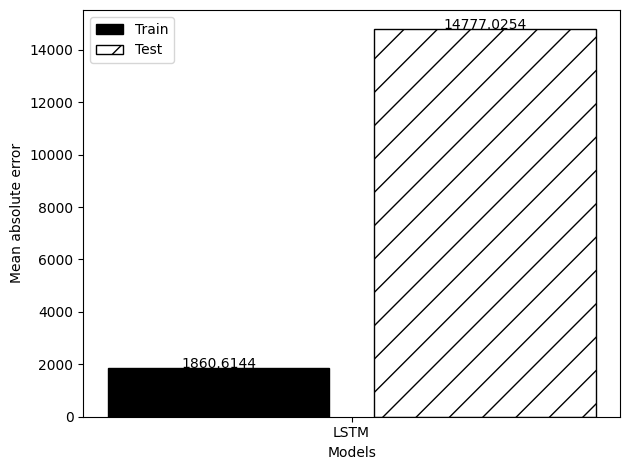

In [26]:
mae_Train = [v[1] for v in Train_performance.values()]
mae_test = [v[1] for v in Test_performance.values()]

x = np.arange(len(Test_performance))

fig, ax = plt.subplots()
ax.bar(x - 0.15, mae_Train, width=0.25, color='black', edgecolor='black', label='Train')
ax.bar(x + 0.15, mae_test, width=0.25, color='white', edgecolor='black', hatch='/', label='Test')
ax.set_ylabel('Mean absolute error')
ax.set_xlabel('Models')

for index, value in enumerate(mae_Train):
    plt.text(x=index - 0.15, y=value, s=str(round(value, 4)), ha='center')
    
for index, value in enumerate(mae_test):
    plt.text(x=index + 0.15, y=value, s=str(round(value, 4)), ha='center')

# plt.ylim(0, 0.33)
plt.xticks(ticks=x, labels=Test_performance.keys())
plt.legend(loc='best')
plt.tight_layout()

plt.savefig('figures/BTC-MA_7.png', dpi=300)